In [1]:
from typing import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
results = {
    'small': '../artifacts/csv-results/scaling-0sh-wandb-export/scale-relation-small.csv',
    'base': '../artifacts/csv-results/scaling-0sh-wandb-export/scale-relation-base.csv',
    'large': '../artifacts/csv-results/scaling-0sh-wandb-export/scale-relation-large.csv',
}

SHOT_SIZES = {
    'small': '32',
    'base': '16*2',
    'large': '4*8',
}

DEBERTA_SIZES = {
    'small': '44m',
    'base': '86m',
    'large': '304m',
}

SIZES = ["2m", "16m", "53m", "125m", "244m", "422m", "1b", "2b", "4b", "8b", "27b", "128b"]



def select_and_rename(df: pd.DataFrame, a_size: str, bs: str) -> pd.DataFrame:
    # Extract and rename the columns we care about
    # "deberta-small-for-128b-bs32-0sh-instance-split - eval/loss"
    selector_renamer = {
        **{f'deberta-{a_size}-for-{s}-bs{bs}-0sh-instance-split - eval/loss': f'a-{a_size}-{s}-loss' for s in SIZES},
        **{f'deberta-{a_size}-for-{s}-bs{bs}-0sh-instance-split - eval/roc_auc': f'a-{a_size}-{s}-roc_auc' for s in SIZES},
        **{f'deberta-{a_size}-for-{s}-bs{bs}-0sh-instance-split - eval/conf_absolute_roc_auc': f'a-{a_size}-{s}-roc_auc-absolute-self' for s in SIZES},
        **{f'deberta-{a_size}-for-{s}-bs{bs}-0sh-instance-split - eval/conf_normalized_roc_auc': f'a-{a_size}-{s}-roc_auc-normalised-self' for s in SIZES},
        **{f'deberta-{a_size}-for-{s}-bs{bs}-0sh-instance-split - eval/conf_distribution_roc_auc': f'a-{a_size}-{s}-roc_auc-task-static' for s in SIZES},
    }
    # df = df.rename(columns=selector_renamer)[selector_renamer.values()] # type: ignore
    for col in selector_renamer.keys():
        if col not in df.columns:
            print(f'Warning: {col} not present')
    df = df[selector_renamer.keys()] # type: ignore
    df = df.rename(columns=selector_renamer)
    return df

def select_by_min_loss(df):
    # Select the values with minimum loss for each shot count and truncation side
    df = df.transpose()
    def by_min_loss(row):
        a, a_size, size, *_tail = row.name.split('-')
        name = f'a-{a_size}-{size}-loss'
        step = df.loc[name].idxmin()
        return row[step]
    df = df.apply(by_min_loss, axis=1).to_frame()
    return df

def columnify(df):
    df = df.copy()
    df['assessor_size'] = [s.split('-')[1] for s in df.index]
    df['size'] = [s.split('-')[2] for s in df.index]
    df['metric'] = ['-'.join(s.split('-')[3:]) for s in df.index]
    df.rename(columns={0: 'value'}, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

def prepare(a_size: str) -> pd.DataFrame:
    df = pd.read_csv(results[a_size])
    df = select_and_rename(df, a_size, SHOT_SIZES[a_size])
    df = select_by_min_loss(df)
    df = columnify(df)
    return df

df = pd.concat([prepare(a_size) for a_size in results.keys()])

df.head(20)



,value,assessor_size,size,metric
0,0.514616,small,2m,loss
1,0.517620,small,16m,loss
2,0.500188,small,53m,loss
3,0.507371,small,125m,loss
4,0.515024,small,244m,loss
5,0.519713,small,422m,loss
6,0.510603,small,1b,loss
7,0.516318,small,2b,loss
8,0.535220,small,4b,loss
9,0.530896,small,8b,loss


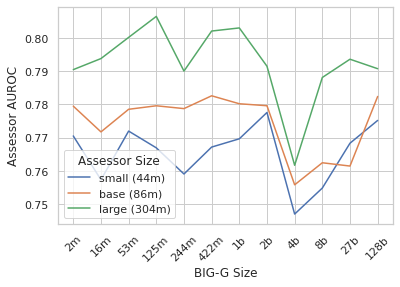

In [54]:
def plot(df: pd.DataFrame):
    df = df.copy()
    sns.set_theme(style="whitegrid")
    df['assessor_size'] = df['assessor_size'].map(lambda s: f"{s} ({DEBERTA_SIZES[s]})")
    df = df.rename(columns={'value': 'Assessor AUROC'})
    df = df.rename(columns={'assessor_size': 'Assessor Size'})
    df = df.rename(columns={'size': 'BIG-G Size'})
    ax = sns.lineplot(
        data=df.loc[(df.metric == 'roc_auc')], 
        x='BIG-G Size', y='Assessor AUROC',
        hue='Assessor Size')
    plt.xticks(rotation=45)
    # ax.set_ylim(0.72, 0.85)

plot(df)